In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import timm
from PIL import Image
import glob
import csv
import random
import numpy as np
import os
import pandas as pd
import wandb
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score,roc_curve,auc,balanced_accuracy_score,accuracy_score
from base_model import InstanceClassifier, AttDual, DSMILNet
import datetime, copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(20221028)


In [3]:
wandb.init(project="Histo_Combined", name="DSMILATT_1031")
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: u2coldplay. Use `wandb login --relogin` to force relogin


In [4]:
def get_feats_df(path):
    """
    Collects the features files from the files in the given path.
    """
    feats_files = sorted(glob.glob(os.path.join(path, "*", "*.csv"), recursive=True))
    labels = []
    for file in feats_files:

        label = file.split("/")[-2]
        label = int(label.split("_")[-2])
        labels.append(label)

    df = pd.DataFrame(feats_files, columns=["feats_files"])
    df["labels"] = labels
    return df
    
    

In [5]:
path = "/restricteddata/skincancer_kuk/Scanned_WSI/Datasets/Base20X_Dataset"
path_vig = "/restricteddata/skincancer_kuk/Scanned_WSI/Datasets/VIG20X_Dataset"
path_combined = "/system/user/publicwork/yitaocai/Master_Thesis/Combined20X_Dataset"

df  =  get_feats_df(path)
df = shuffle(df).reset_index(drop=True)
df
df_vig = get_feats_df(path_vig)
df_vig = shuffle(df_vig).reset_index(drop=True)
df_vig
df_combined = get_feats_df(path_combined)
df_combined = shuffle(df_combined).reset_index(drop=True)
df_combined



,feats_files,labels
0,/system/user/publicwork/yitaocai/Master_Thesis...,0
1,/system/user/publicwork/yitaocai/Master_Thesis...,1
2,/system/user/publicwork/yitaocai/Master_Thesis...,1
3,/system/user/publicwork/yitaocai/Master_Thesis...,1
4,/system/user/publicwork/yitaocai/Master_Thesis...,0
...,...,...
496,/system/user/publicwork/yitaocai/Master_Thesis...,1
497,/system/user/publicwork/yitaocai/Master_Thesis...,0
498,/system/user/publicwork/yitaocai/Master_Thesis...,0
499,/system/user/publicwork/yitaocai/Master_Thesis...,0


In [6]:
def get_bag_feats(feats_df):
    feats = pd.read_csv(feats_df.iloc[0], header=None)
    feats = feats.to_numpy()
    label = np.zeros(3)
    label[int(feats_df.iloc[1])] = 1
    return feats, label
    

In [7]:

#Round1 Best search
# class Config:
#     grad_norm_clip = 0.8188
#     alpha = 0.5122
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.002578
#     weight_decay = 1e-5
#     batch_size = 128
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "sgd"
#     scheduler = "cosine"

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

#Round2 Best search
# class Config:
#     grad_norm_clip = 1.1064267106898578
#     alpha = 0.4332472392227129
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.0017927233496779717
#     weight_decay = 0.0001
#     batch_size = 40
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "adam"
#     scheduler = "cosine"

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

#SunnySearch
class Config:
    grad_norm_clip = 1.02580285460309
    alpha = 0.849435264741892
    in_size  = 2000
    classes = 3
    out_size = 3
    dropout = 0.3
    lr = 0.0203373691328209
    weight_decay = 0.0001
    # batch_size = 40
    epochs = 20
    device = torch.device("cuda:0")
    optimizer = "SGD"
    scheduler = "cosine"
    betas = (0.5, 0.9)
    momentum = 0.9
    minlr = 0.000005
    thresh_prob = 0

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)


#MorningSearch

# class Config:
#     grad_norm_clip = 1.02580285460309
#     alpha = 0.7893775434808594
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.020319308924998204
#     weight_decay = 0.00001
#     # batch_size = 40
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "SGD"
#     scheduler = "cosine"
    # betas = (0.5, 0.9)
    # momentum = 0.9

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

In [69]:
config = Config()


3

In [25]:
sweep_config = {
    'method': 'bayes', #grid, random
    }
metric = {
    'name': 'avg_score',
    'goal': 'maximize'   
    }
early_terminate = {
    'type': 'hyperband',
 
    'max_iter': 8,
    's': 2,

    }

sweep_config['metric'] = metric
sweep_config['early_terminate'] = early_terminate

In [26]:
parameters_dict = {
    'optimizer': {'values': ['Adam','Adamax','ASGD', 'SGD']},
    # 'lambd':{ 'distribution': 'uniform','min': 0,'max': 0.1},
    # 'eps':{ 'distribution': 'uniform','min': 0,'max': 0.1},
    # 'factor':{ 'distribution': 'uniform','min': 0,'max': 1},
    # 'patience':{ 'distribution': 'q_log_uniform_values','min': 0,'max': 10},
    # 'alph':{'distribution': 'uniform','min': 0.5,'max': 1},
    'scheduler': {'values': ['cosine',  'plateau']},
    'dropout': {'distribution': 'uniform','min': 0,'max': 1},
    'epochs': {'value': 6},
    'lr': { 'distribution': 'uniform','min': 0,'max': 0.1},
    'weight_decay':{ 'distribution': 'uniform','min': 0,'max': 0.1},

    'alpha': {'distribution': 'uniform','min': 0.5,'max': 1},
    'grad_norm_clip': {'distribution': 'normal','mu': 1,'sigma': 0.1},   
    'device': {'values': ['cuda:0']},        
    'in_size': {'values': [2000]},
    'classes': {'values': [3]},
    'out_size': {'values': [3]},
    'betas': {'values': [(0.5,0.9), (0.9, 0.999), (0.6,0.999), (0.7,0.999), (0.8,0.999)]},
    'momentum':{'distribution': 'uniform','min': 0.5,'max': 1},
    'minlr':{'distribution': 'uniform','min': 0,'max': 0.00001},
    'thresh_prob':{'distribution': 'uniform','min': 0,'max': 1},
    }

sweep_config['parameters'] = parameters_dict

In [27]:
sweep_id = wandb.sweep(sweep_config, project="Bayes_search_1031")

Create sweep with ID: g78gh9ig
Sweep URL: https://wandb.ai/u2coldplay/Bayes_search_1031/sweeps/g78gh9ig


In [33]:
## model
class AttentionBase(nn.Module):
    def __init__(self,config):
        super(AttentionBase, self).__init__()
        
        self.repr_length = config.in_size # size of representation per tile
        self.D = 128                               # N = batch size
        self.att = 1

        self.attention = nn.Sequential(             # N * repr_length
            nn.Linear(self.repr_length, self.D),    # N * D
            nn.Tanh(),                              # N * D
            nn.Linear(self.D, self.att)             # N * att
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.repr_length*self.att, config.out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.float()                              # N * repr_lenght
        print('x: ', x.shape)

        A = self.attention(x)                      # N * att
        A = torch.transpose(A, 1,0)                # att * N
        A = nn.functional.softmax(A, dim=1)        # softmax over N
        #print('A: ', A)#.shape)
        M = torch.mm(A, x)             # att * repr_length
        #print('M: ', M)
        
        out_prob = self.classifier(M)
        #print('out_prob', out_prob)
        out_hat = torch.ge(out_prob, 0.5).float()
        
        return out_prob, out_hat, A
    
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()
        
        return error, Y_hat
    
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob)) # negative log bernoulli
        
        return neg_log_likelihood, A

In [57]:
def run_bags(model, train_df, optimizer, criterion, config):
    model.train()
    train_df = shuffle(train_df).reset_index(drop=True)
    Loss = 0 

    for i in range(len(train_df)):
        optimizer.zero_grad()
        feats, label = get_bag_feats(train_df.iloc[i])
        
        feats = torch.from_numpy(feats).float().to(config.device)
        label = torch.from_numpy(label).float().to(config.device)

        out_prob, out_hat, A = model(feats)
        error = 1. - out_hat.eq(label).cpu().float().mean().item()
        
        loss, _ = model.calculate_objective(feats, label)
        # print('loss: ', loss)
        loss = loss.mean()
            
        loss.backward()
        optimizer.step()


        Loss += loss.item()
    # print('Training (shuffled) bag [%d/%d] bag loss: %.4f' % (i, len(train_df), loss.item()))
        wandb.log({"Step Train Loss": loss.item()})
    return Loss / len(train_df)


In [58]:
def compute_roc(label, pred, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(label[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [59]:
def optimal_thresh(fpr, tpr, thresholds, config):
    loss = (fpr - tpr) - config.thresh_prob * tpr / (fpr + tpr + 1)
    idx = np.argmin(loss, axis=0)
    return fpr[idx], tpr[idx], thresholds[idx]

In [60]:
def multi_label_roc(labels, predictions, config):
    fprs = []
    tprs = []
    thresholds = []
    thresholds_optimal = []
    aucs = []
    if len(predictions.shape)==1:
        predictions = predictions[:, None]
    for c in range(config.classes):
        label = labels[:, c]
        prediction = predictions[:, c]
        fpr, tpr, threshold = roc_curve(label, prediction, pos_label=1)
        fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold,config)
        c_auc = roc_auc_score(label, prediction)
        aucs.append(c_auc)
        thresholds.append(threshold)
        thresholds_optimal.append(threshold_optimal)
    return aucs, thresholds, thresholds_optimal

In [61]:
def plot_auc(pred,y,config):
    fpr,tpr,roc_auc = dict(),dict(),dict()

    for i in range(config.classes):
    
        fpr[i],tpr[i],_ = roc_curve(y[:,i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr["micro"],tpr["micro"],_ = roc_curve(y.ravel() , pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(config.classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(config.classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= config.classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=[10.8,8.1])
    plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
    )

    plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
    )

    # colors = ["aqua", "darkorange", "cornflowerblue", "green", "red", "purple", "yellow", "blue", "black", "brown", "pink", "grey"]
    colors = ["aqua", "darkorange", "cornflowerblue"]
    classesname = ["NORMAL", "BAS", "SCC"]
    for i, color,name in zip(range(config.classes), colors, classesname):
        plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="  ROC curve of class {0}     (area = {1:0.2f})".format(name, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()

In [62]:
def evaluate_bags(model, valid_df, criterion, config):
    model.eval()
    valid_df= shuffle(valid_df).reset_index(drop=True)
    Loss = 0
    pred = []
    labels = []
    with torch.no_grad():
        for i in range(len(valid_df)):
            feats, label = get_bag_feats(valid_df.iloc[i])
            labels.extend([label])
            feats = torch.from_numpy(feats).float().to(config.device)
            label = torch.from_numpy(label).float().to(config.device)

            out, val_out_hat, _ = model(feats)
            loss, _ = model.calculate_objective(feats, label)
            loss = loss.mean()
            # error = 1. - val_out_hat.eq(label).cpu().float().mean().item()
            # epoch_error_val += error
            pred.extend(out.cpu().detach().numpy())
        
            # print(f'prediction after sigmoid and alpha combination: {pred[-1]}')
            
            Loss += loss.item()
            # print('Testing bag [%d/%d] bag loss: %.4f' % (i, len(valid_df), loss.item()))
            wandb.log({"Step Test Loss": loss.item()})
    # print(f'Prediction : {pred}  size : {len(pred)}')
    pred = np.array(pred)
    labels = np.array(labels)
    # print(f'Labels array : {labels}  size : {labels.shape}')
    auc_value, thresholds, thresholds_optimal = multi_label_roc(labels, pred, config.classes)

    # print(f"Threshold: {thresholds}      Threshold optimal: {thresholds_optimal}")
    
    plot = wandb.plot.roc_curve(np.argmax(labels,axis=1), pred,labels=['NORMAL','BAS','SCC'])
    precision_recall = wandb.plot.pr_curve(np.argmax(labels,axis=1), pred,labels=['NORMAL','BAS','SCC'])
    

    wandb.log({"roc": plot})
    wandb.log({"pr": precision_recall})

    pred = np.where(pred >= thresholds_optimal, 1, 0)

    normal_acc = accuracy_score(labels[:,0], pred[:,0])
    bas_acc = accuracy_score(labels[:,1], pred[:,1])
    scc_acc = accuracy_score(labels[:,2], pred[:,2])
    # normal_acc=balanced_accuracy_score(labels[:,0], pred[:,0]>=thresholds_optimal[0])
    # bas_acc=balanced_accuracy_score(labels[:,1], pred[:,1]>=thresholds_optimal[1])
    # scc_acc=balanced_accuracy_score(labels[:,2], pred[:,2]>=thresholds_optimal[2])
    
    # for i in range(config.classes):
    #     bag_pred = copy.deepcopy(pred[:, i])
    #     bag_pred[pred[:, i]>=thresholds_optimal[i]] = 1
    #     bag_pred[pred[:, i]<thresholds_optimal[i]] = 0
    #     pred[:, i] = bag_pred

    bag_score = 0

    for i in range(0, len(valid_df)):
        bag_score = np.array_equal(labels[i], pred[i]) + bag_score         
    avg_score = bag_score / len(valid_df)

    # return Loss / len(valid_df)
    return Loss / len(valid_df), auc_value, avg_score, normal_acc,bas_acc,scc_acc,pred,labels

In [63]:
split=1
dft = df.iloc[:int(len(df)*split)]
dft_vig = df_vig.iloc[:int(len(df_vig)*split)]
dft_combined = df_combined.iloc[:int(len(df_combined)*split)]

df_test = df.iloc[int(len(df)*split):]
df_test = shuffle(df_test).reset_index(drop=True)
df_vig_test = df_vig.iloc[int(len(df_vig)*split):]
df_vig_test = shuffle(df_vig_test).reset_index(drop=True)
df_combined_test = df_combined.iloc[int(len(df_combined)*split):]
df_combined_test = shuffle(df_combined_test).reset_index(drop=True)

def build_dataloader(df):

    if df == 'df':

        train_df = dft.iloc[:int(len(dft)*0.8)]
        valid_df = dft.iloc[int(len(dft)*0.8):]
       
    elif df == 'df_vig':
        train_df = dft_vig.iloc[:int(len(dft_vig)*0.8)]
        valid_df = dft_vig.iloc[int(len(dft_vig)*0.8):]
  

    elif df == 'df_combined':
        train_df = dft_combined.iloc[:int(len(dft_combined)*0.8)]
        valid_df = dft_combined.iloc[int(len(dft_combined)*0.8):]    

    return train_df, valid_df

In [64]:
dft_combined

,feats_files,labels
0,/system/user/publicwork/yitaocai/Master_Thesis...,0
1,/system/user/publicwork/yitaocai/Master_Thesis...,1
2,/system/user/publicwork/yitaocai/Master_Thesis...,1
3,/system/user/publicwork/yitaocai/Master_Thesis...,1
4,/system/user/publicwork/yitaocai/Master_Thesis...,0
...,...,...
496,/system/user/publicwork/yitaocai/Master_Thesis...,1
497,/system/user/publicwork/yitaocai/Master_Thesis...,0
498,/system/user/publicwork/yitaocai/Master_Thesis...,0
499,/system/user/publicwork/yitaocai/Master_Thesis...,0


In [65]:
def build_optimizer(model,config):
    if config.optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=config.lr, momentum=config.momentum)
    elif config.optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=config.betas, weight_decay=config.weight_decay)
    elif config.optimizer == "Adamax":
        optimizer = torch.optim.Adamax(model.parameters(), lr=config.lr, betas=config.betas, weight_decay=config.weight_decay)

    elif config.optimizer == "ASGD":
        optimizer = torch.optim.ASGD(model.parameters(), lr=config.lr,  weight_decay=config.weight_decay)
    return optimizer

def build_scheduler(optimizer, config):
    
    if config.scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs, config.minlr)
    elif config.scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)
    return scheduler

In [66]:



def train(config=None):

    # with wandb.init(config):
    #     config = wandb.config
      
        train_df, valid_df = build_dataloader('df_combined')
        # ins_classifier = InstanceClassifier(config).to(config.device)
        # bag_classifier = AttDual(config).to(config.device)

        model = AttentionBase(config).to(config.device)
        wandb.watch(model, log_freq=100, log_graph=True)
        criterion = nn.BCEWithLogitsLoss()

        optimizer = build_optimizer(model, config)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs, 0.000005)
        scheduler = build_scheduler(optimizer, config)

        save_dir = "/system/user/publicwork/yitaocai/Master_Thesis/model"
        d = datetime.date.today().strftime("%m%d%Y")
        best_score = 0
        auc_list = []
        n_acc = []
        b_acc = []
        s_acc = []
        for e in range(config.epochs):
            print("Epoch %d" % e)
            train_loss = run_bags(model, train_df, optimizer, criterion, config)
           
            valid_loss,aucs,avg_score,normal_acc,bas_acc,scc_acc,pred,labels = evaluate_bags(model, valid_df, criterion, config)

            if config.scheduler == "plateau":
                scheduler.step(valid_loss)
            else:
                scheduler.step()

            n_acc.append(normal_acc)
            b_acc.append(bas_acc)
            s_acc.append(scc_acc)    
            auc_list.append(aucs)
        
            current_score = (sum(aucs) + avg_score)/2

            if e % 10 == 0:
                plot_auc(pred,labels,config)
                print(f"prediction: {pred}     labels: {labels}")
                
            wandb.log({'Train Loss': train_loss})
            wandb.log({'loss': valid_loss})
            wandb.log({'Average Score': avg_score})
            # if current_score >= best_score:
            #     best_score = current_score
            #     save_path = os.path.join(save_dir, config.optimizer+"_"+config.scheduler  +"_"+ d + ".pt")
            #     torch.save(model.state_dict(), save_path)
            
        balanced_acc = [n_acc,b_acc,s_acc]
        wandb.log({"Balanced Accuracy": wandb.plot.line_series(xs =[e for e in range(config.epochs)], ys = balanced_acc, keys=["Normal", "Basal", "SCC"],title = "Balanced Accuracy",xname = "Epochs")})


In [36]:
model_path ="/system/user/publicwork/yitaocai/Master_Thesis/model/1.9335529176705646_0.0203373691328209_10242022.pt"
config = Config(model_path=model_path)
def test(config=None):

    test_df = df_combined_test
    ins_classifier = InstanceClassifier(config).to(config.device)
    bag_classifier = AttDual(config).to(config.device)
    model = DSMILNet(ins_classifier, bag_classifier).to(config.device)
    model.load_state_dict(torch.load(config.model_path))
    criterion = nn.BCEWithLogitsLoss()
    test_loss,aucs,avg_score,_,_,_,_ = evaluate_bags(model, test_df, criterion, config)
        
  

In [67]:
train(config)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0


AttributeError: 'int' object has no attribute 'classes'

In [29]:
wandb.agent(sweep_id, train, count=12)

wandb: Agent Starting Run: c37vyugc with config:
wandb: 	alpha: 0.5489988542259743
wandb: 	betas: [0.9, 0.999]
wandb: 	classes: 3
wandb: 	device: cuda:0
wandb: 	dropout: 0.5029469610062709
wandb: 	epochs: 6
wandb: 	grad_norm_clip: 1.0063996274960287
wandb: 	in_size: 2000
wandb: 	lr: 0.013802931100181416
wandb: 	minlr: 1.268199011181386e-06
wandb: 	momentum: 0.7218994203311715
wandb: 	optimizer: ASGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	thresh_prob: 0.027939363904391334
wandb: 	weight_decay: 0.0226213846745036
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0


Run c37vyugc errored: RuntimeError('grad can be implicitly created only for scalar outputs')
wandb: ERROR Run c37vyugc errored: RuntimeError('grad can be implicitly created only for scalar outputs')
wandb: Agent Starting Run: 79ril8lg with config:
wandb: 	alpha: 0.8309099741463575
wandb: 	betas: [0.6, 0.999]
wandb: 	classes: 3
wandb: 	device: cuda:0
wandb: 	dropout: 0.05857728661083139
wandb: 	epochs: 6
wandb: 	grad_norm_clip: 1.04969641184876
wandb: 	in_size: 2000
wandb: 	lr: 0.09182676853854324
wandb: 	minlr: 3.4680931523481064e-06
wandb: 	momentum: 0.8621970317852622
wandb: 	optimizer: ASGD
wandb: 	out_size: 3
wandb: 	scheduler: plateau
wandb: 	thresh_prob: 0.5962016128498183
wandb: 	weight_decay: 0.03712539899842331
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0


wandb: Ctrl + C detected. Stopping sweep.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Threshold: [array([1.9797093 , 0.97970927, 0.9714267 , 0.97075474, 0.96788687,
       0.965797  , 0.9596155 , 0.9595138 , 0.9579681 , 0.95774263,
       0.9571521 , 0.9542452 , 0.9538714 , 0.95326483, 0.9526144 ,
       0.95235026, 0.94768226, 0.947079  , 0.9447376 , 0.9441571 ,
       0.9428643 , 0.9413467 , 0.9370218 , 0.9319437 , 0.9300291 ,
       0.9298376 , 0.9257341 , 0.9254225 , 0.9240669 , 0.92371523,
       0.91718334, 0.9130774 , 0.90693915, 0.9036746 , 0.9036544 ,
       0.8982539 , 0.8977711 , 0.8973061 , 0.8897689 , 0.88696903,
       0.8842779 , 0.8815736 , 0.8808318 , 0.8730302 , 0.8583518 ,
       0.8531384 , 0.8493359 , 0.84441614, 0.3191893 ], dtype=float32), array([1.6601985 , 0.66019845, 0.11344558, 0.11320022, 0.05764873,
       0.05737334, 0.04386602, 0.04336413, 0.03928716, 0.03923107,
       0.03824739, 0.03815589, 0.03712207, 0.03619726, 0.03580247,
       0.03525701, 0.03422661, 0.0319744 , 0.03058983, 0.03046444,
       0.02875261, 0.02857479, 0.0265

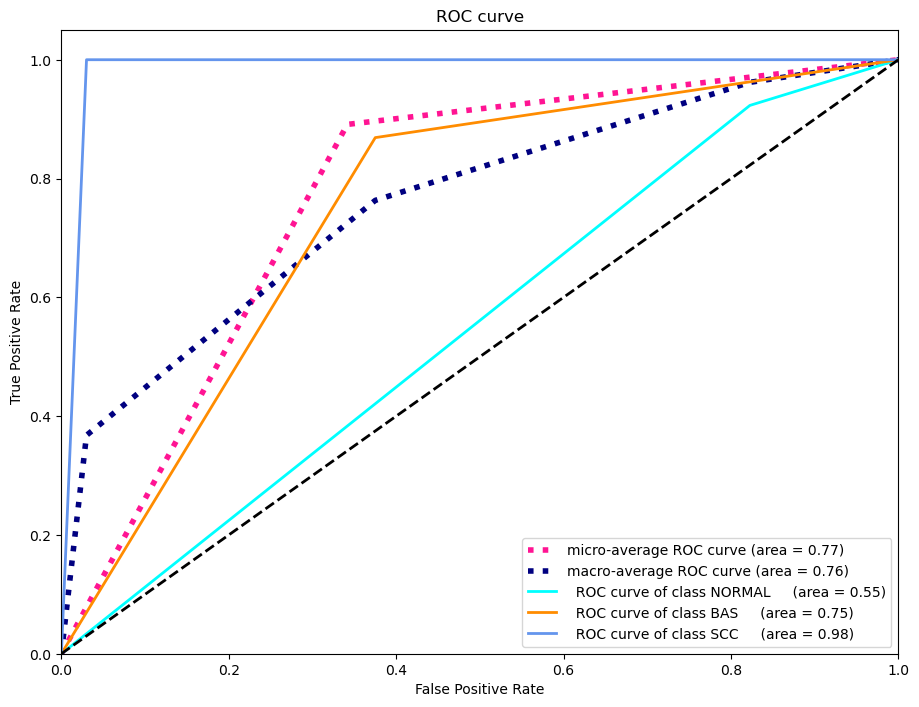

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1.

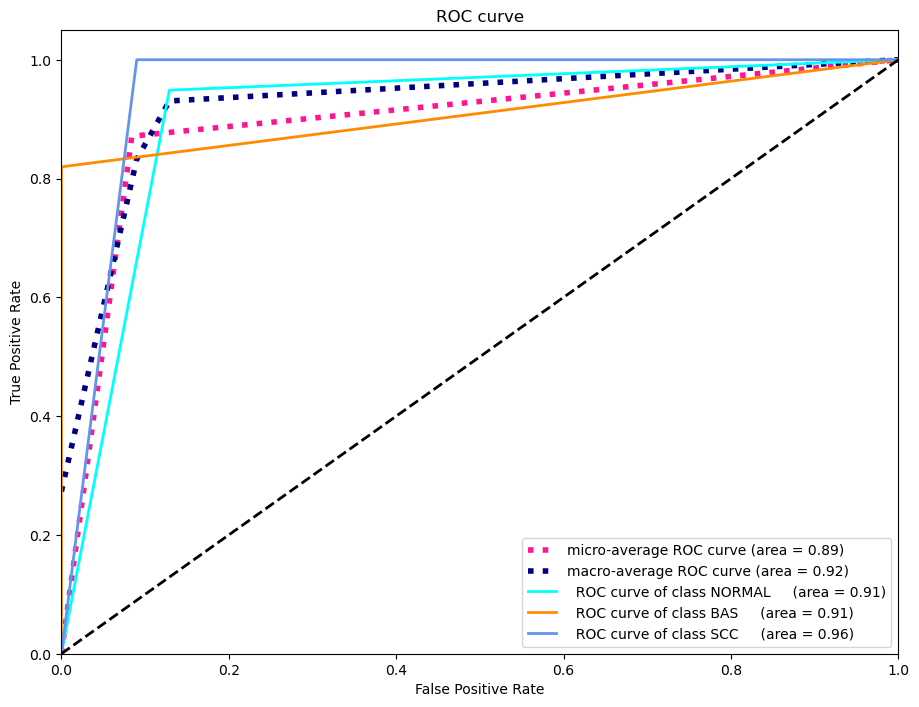

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1.

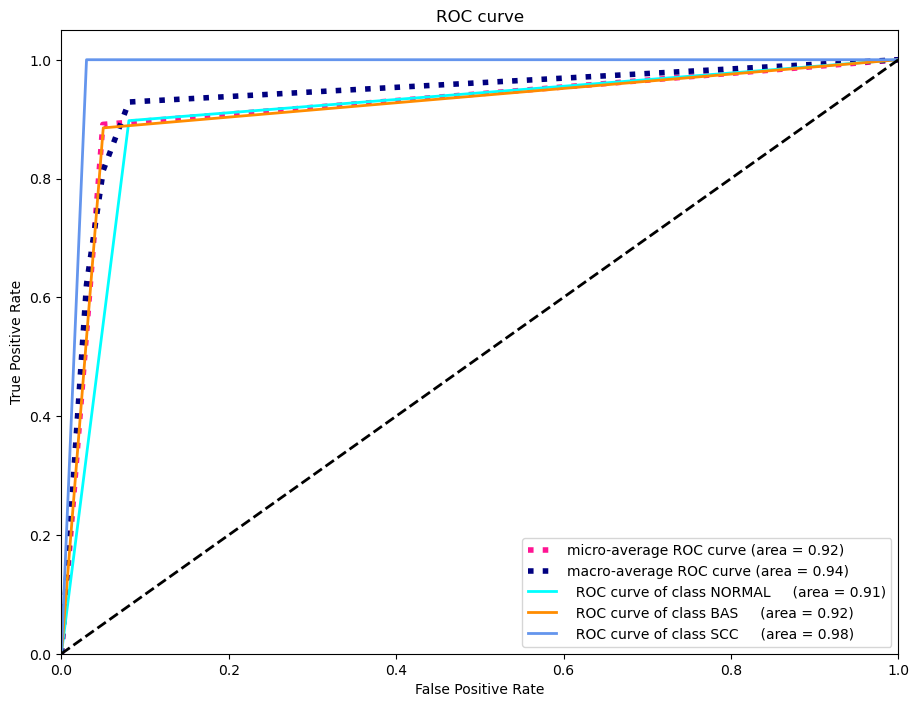

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1.

In [21]:
train(config)

Epoch 0


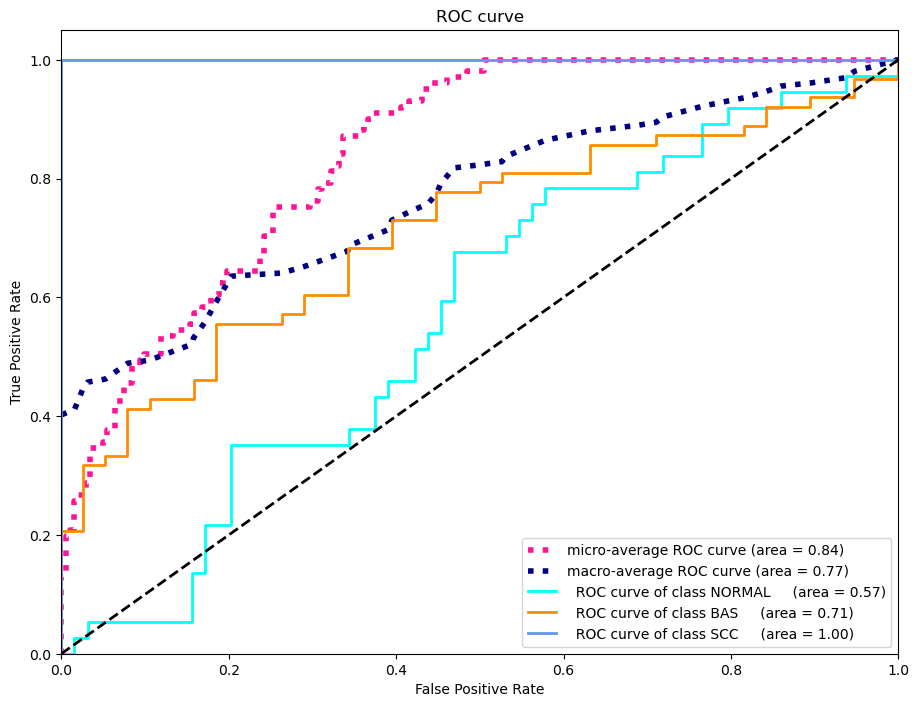

Epoch 1


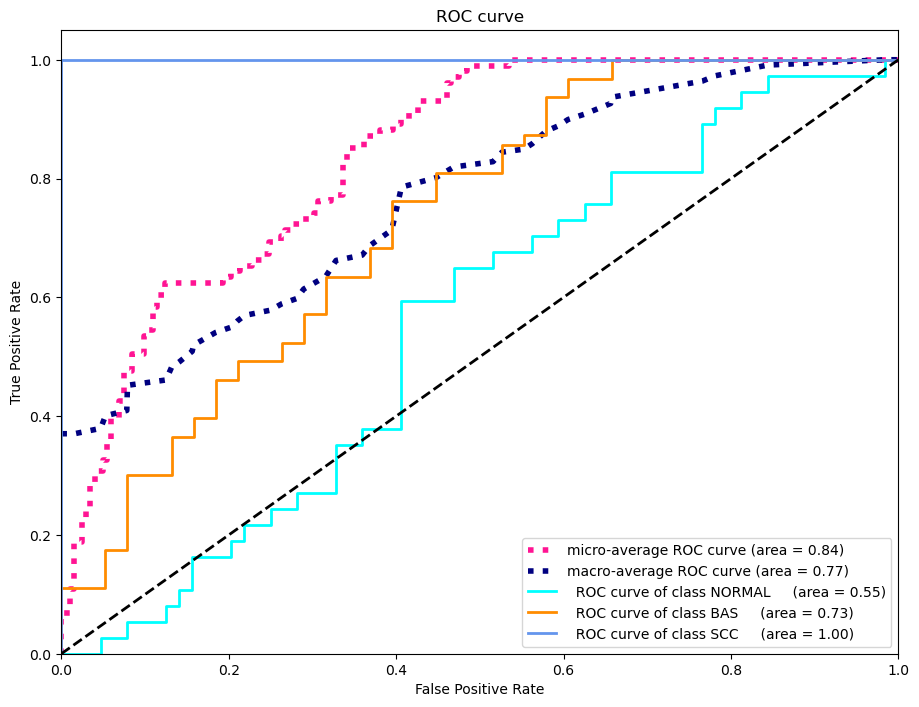

Epoch 2


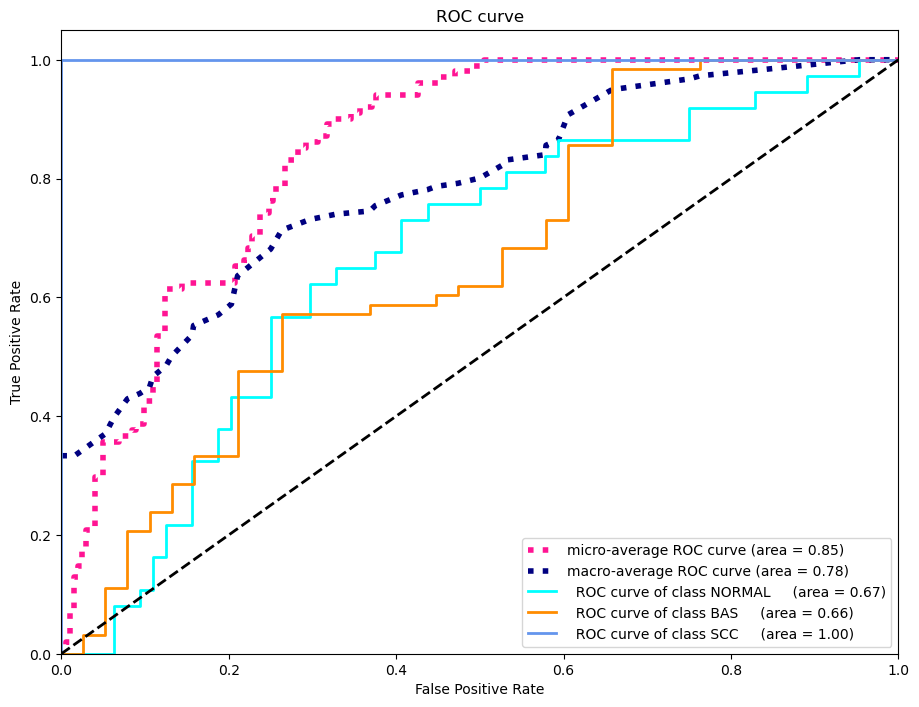

Epoch 3


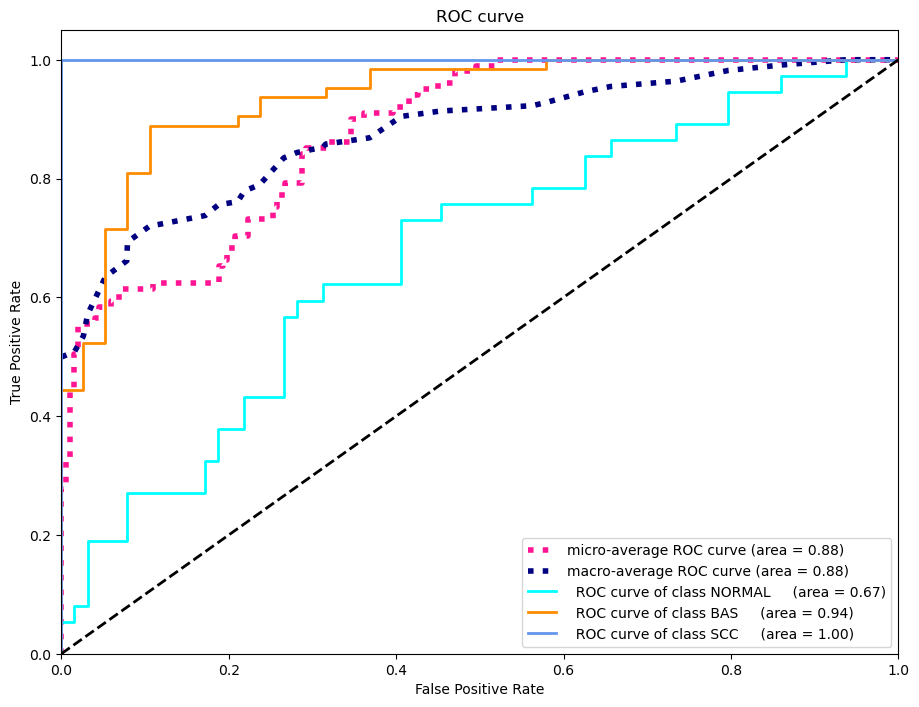

Epoch 4


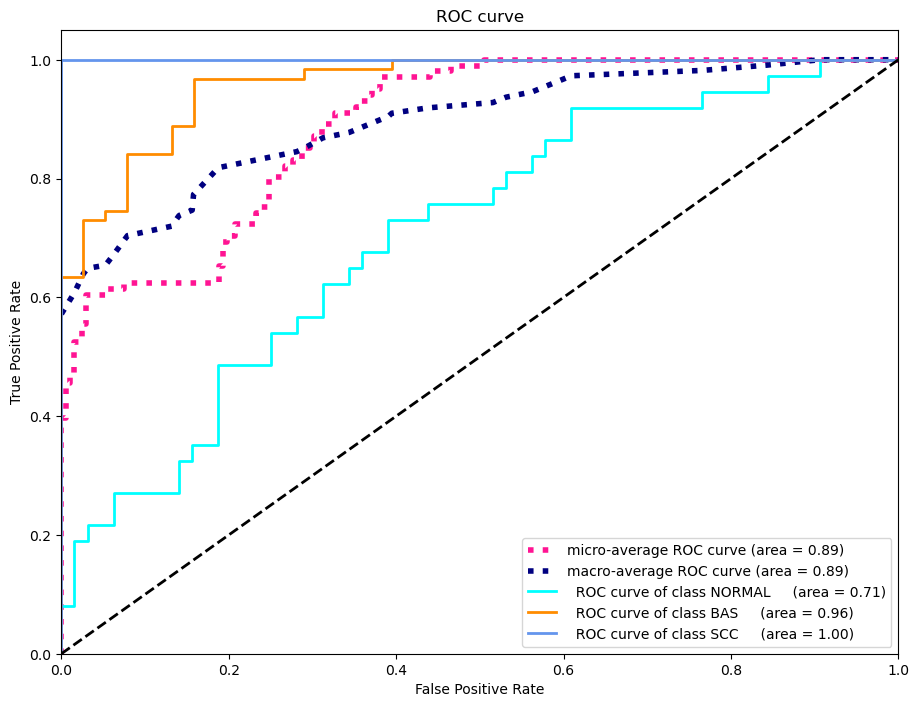

Epoch 5


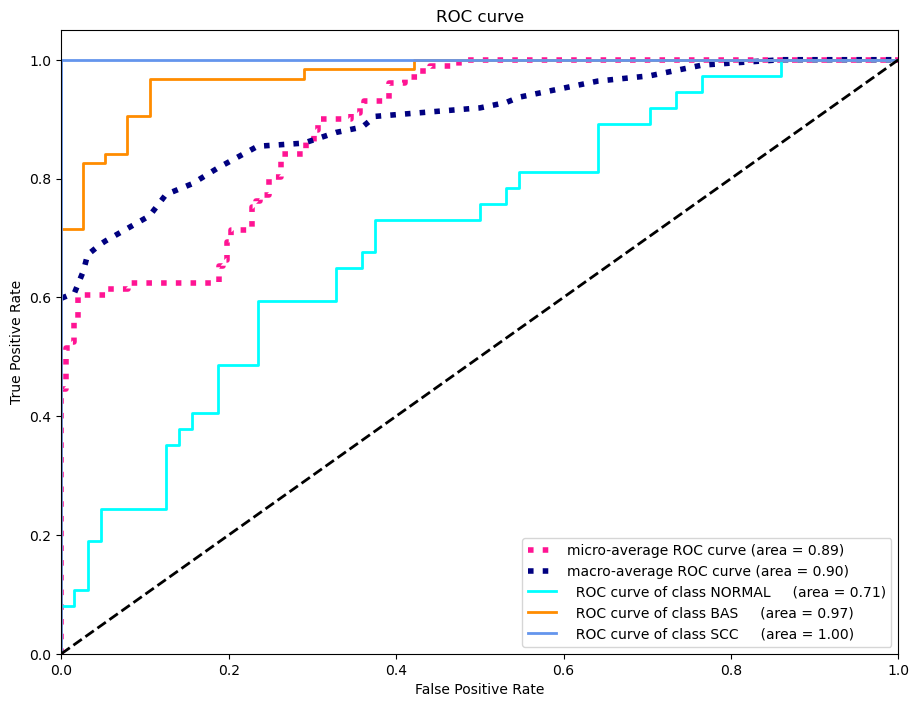

Epoch 6


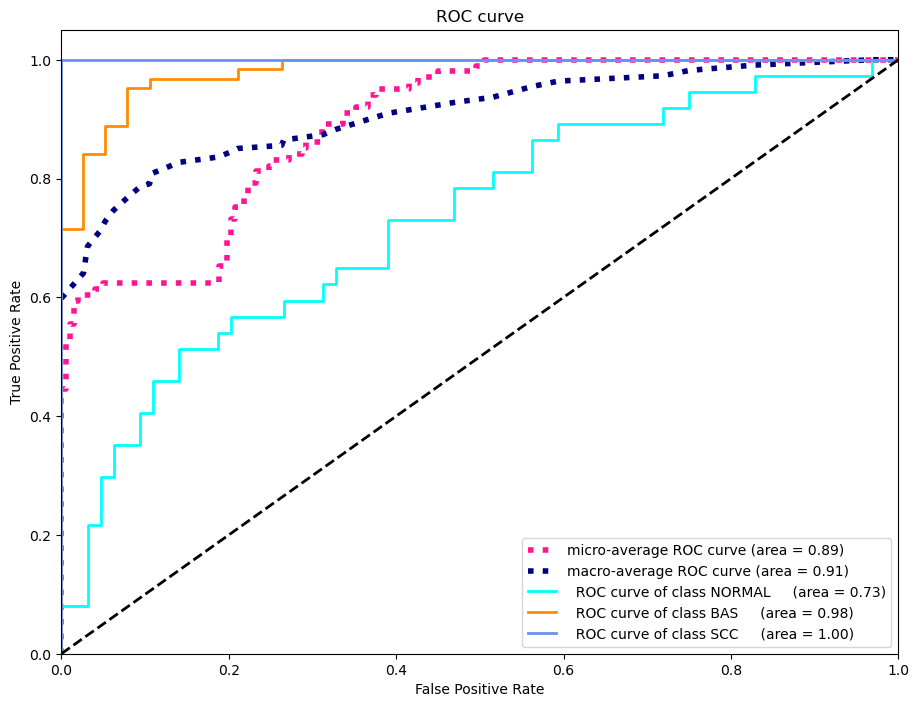

Epoch 7


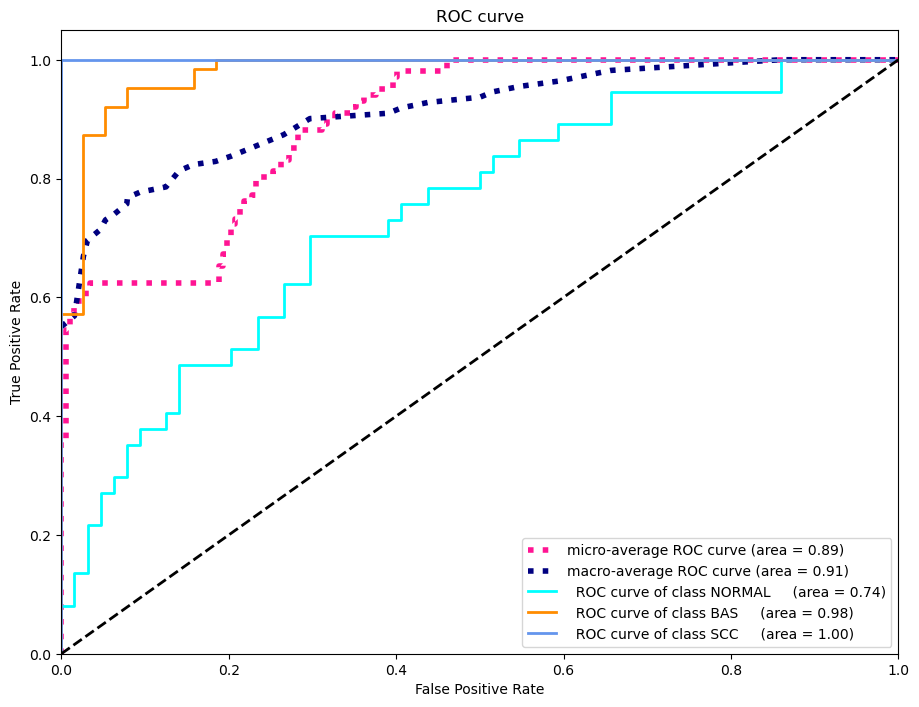

Epoch 8


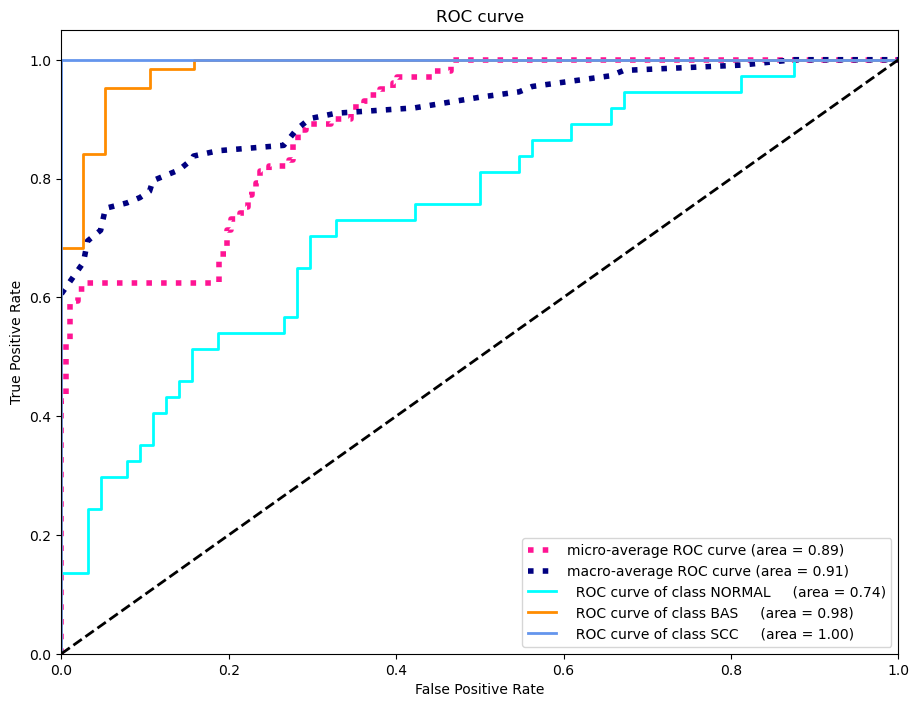

Epoch 9


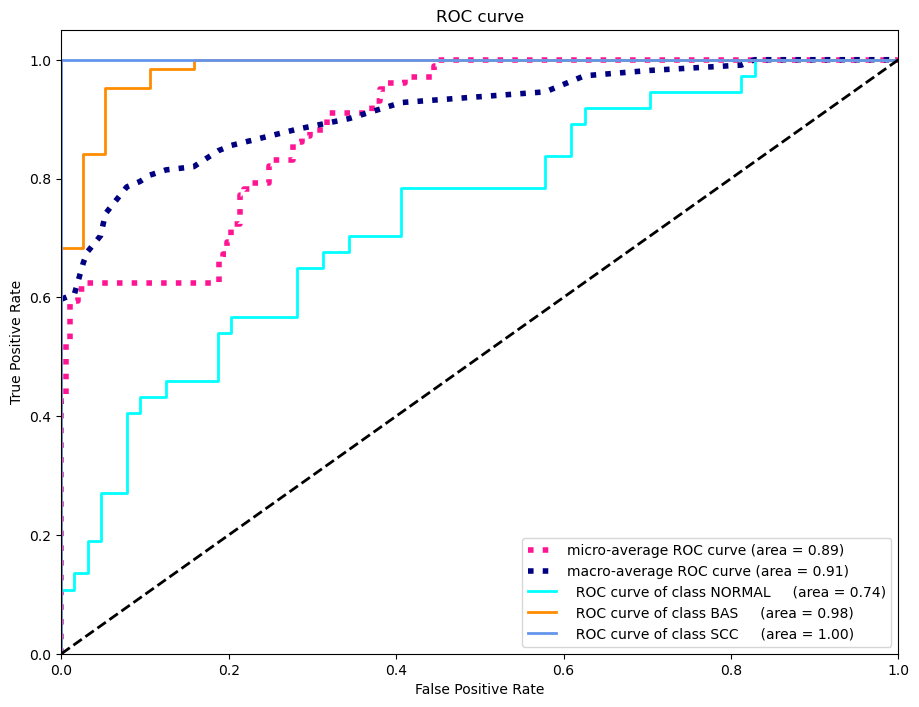

Epoch 10


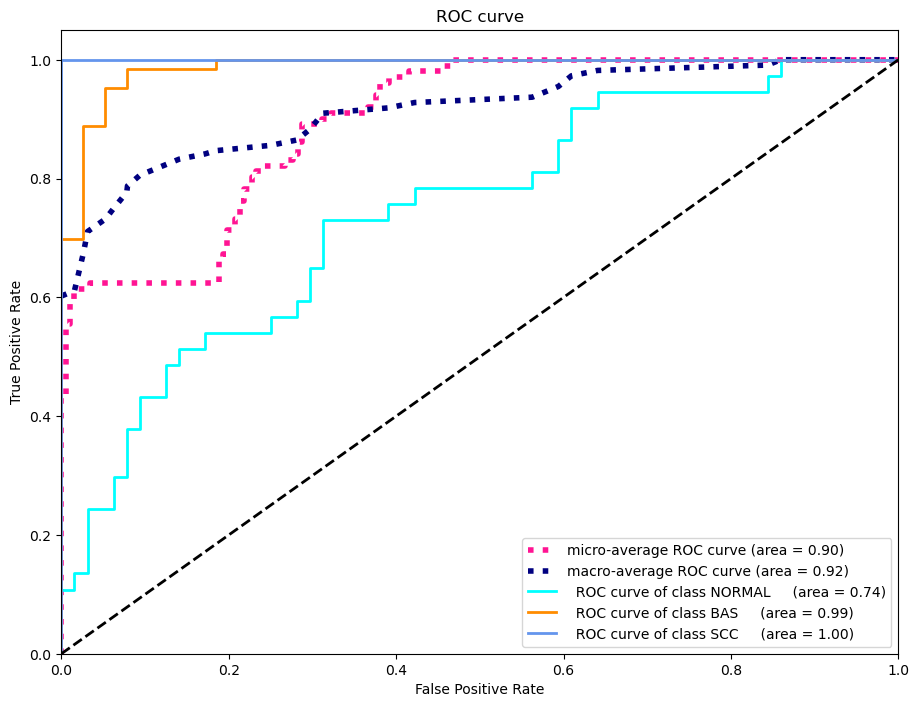

Epoch 11


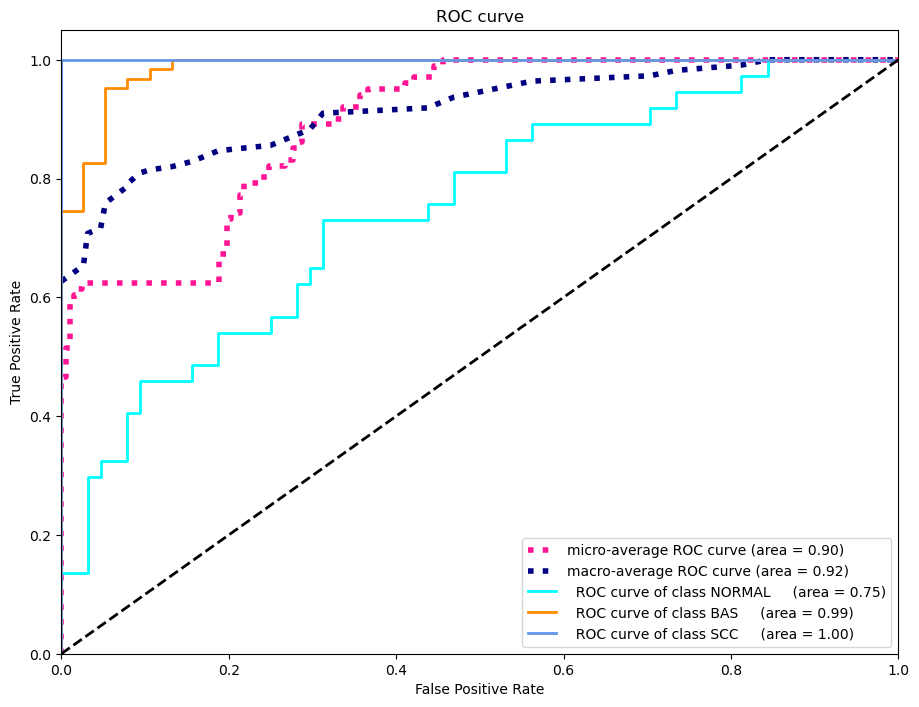

Epoch 12


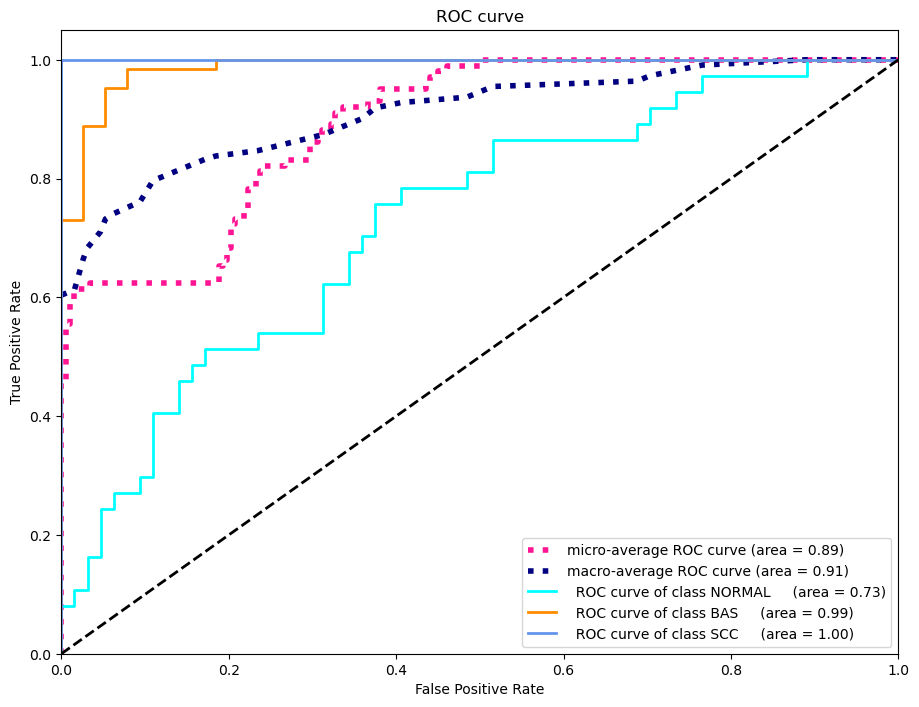

Epoch 13


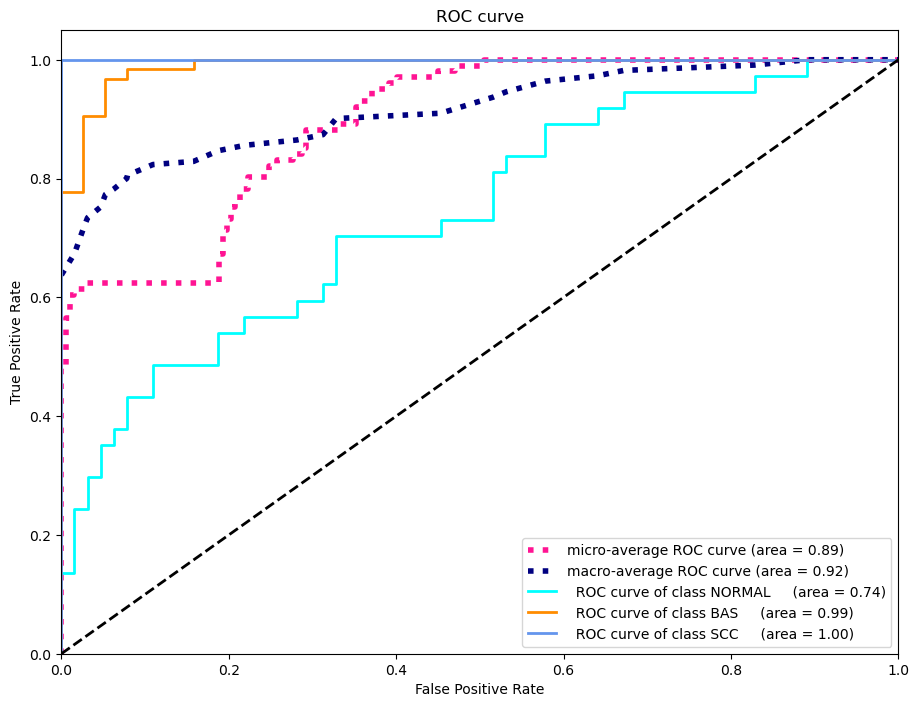

Epoch 14


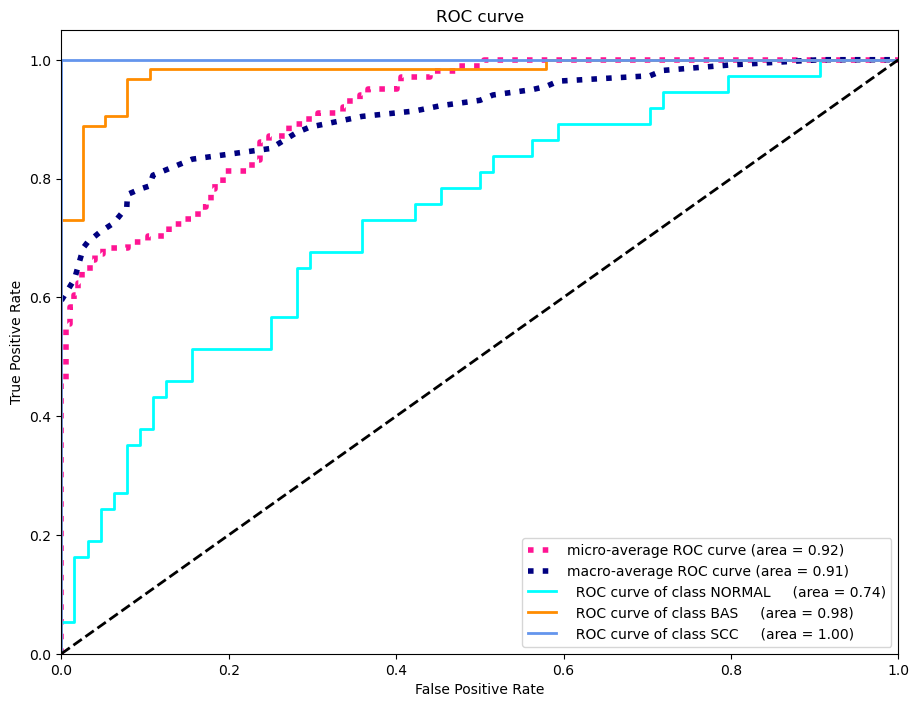

Epoch 15


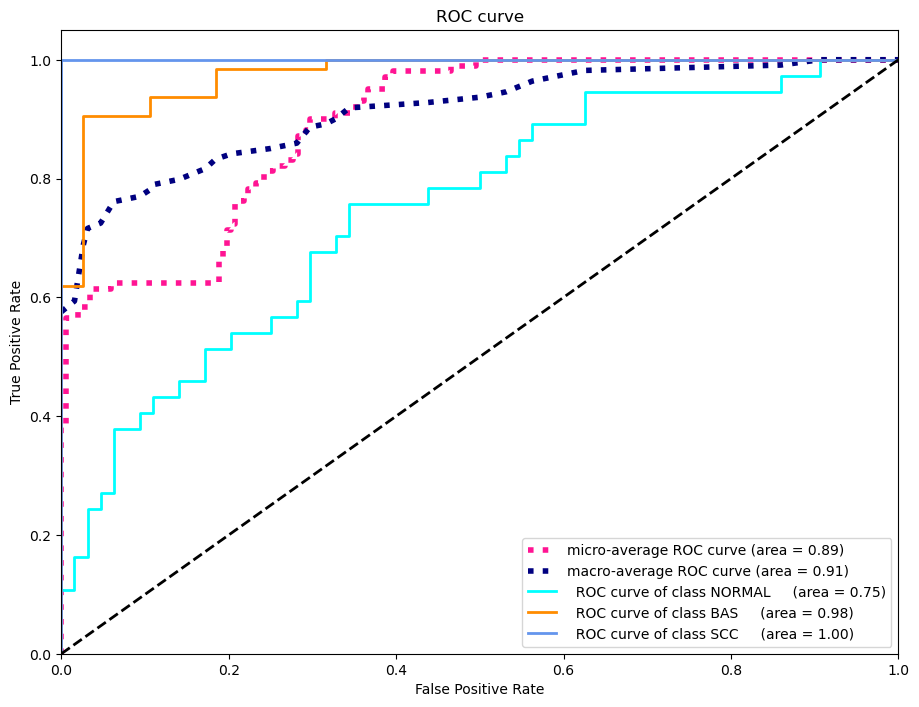

Epoch 16


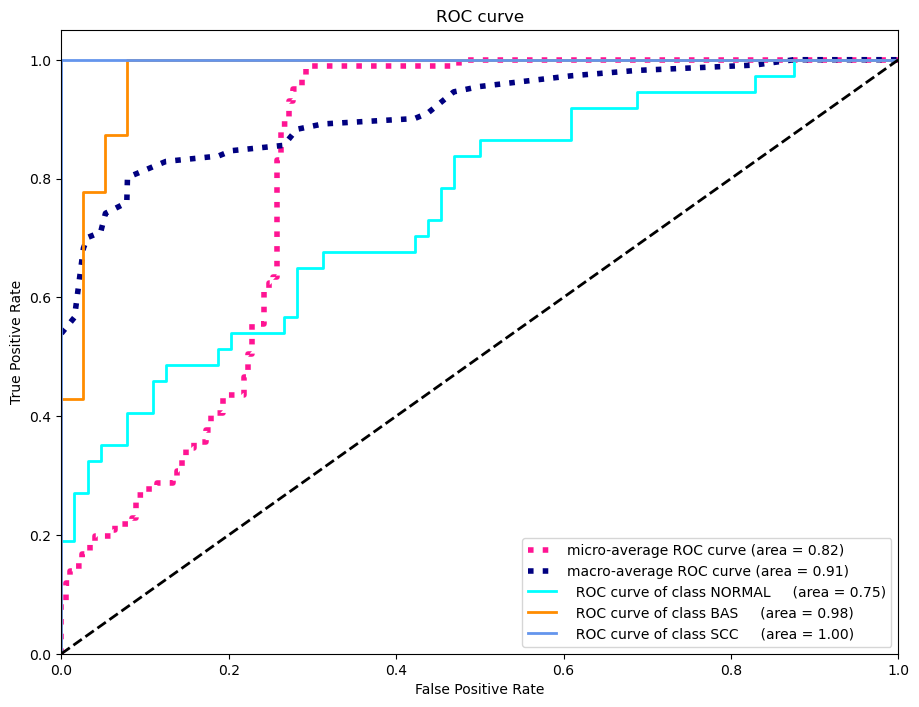

Epoch 17


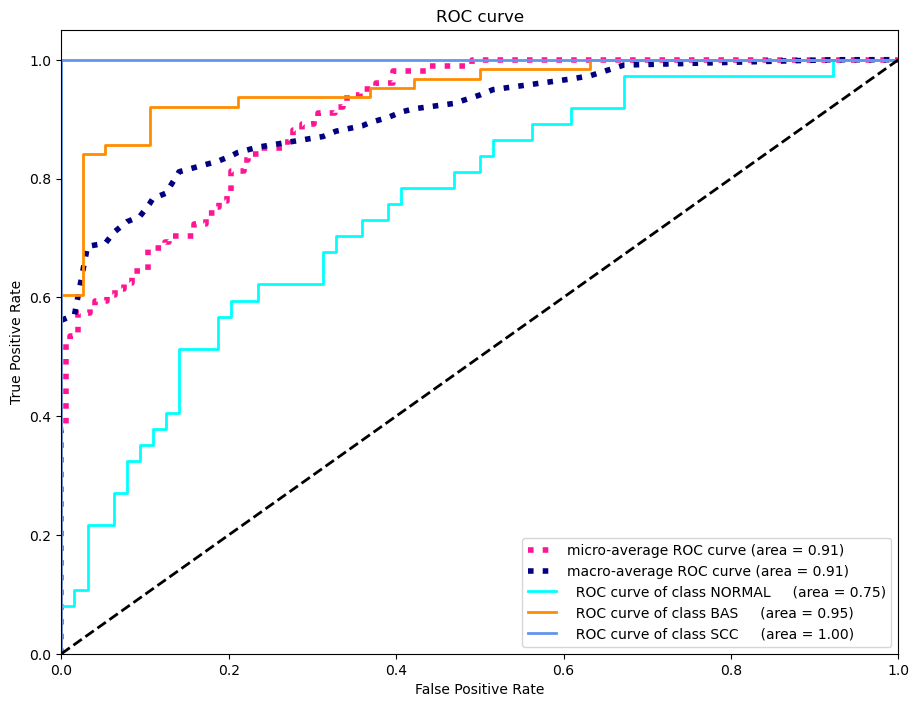

Epoch 18


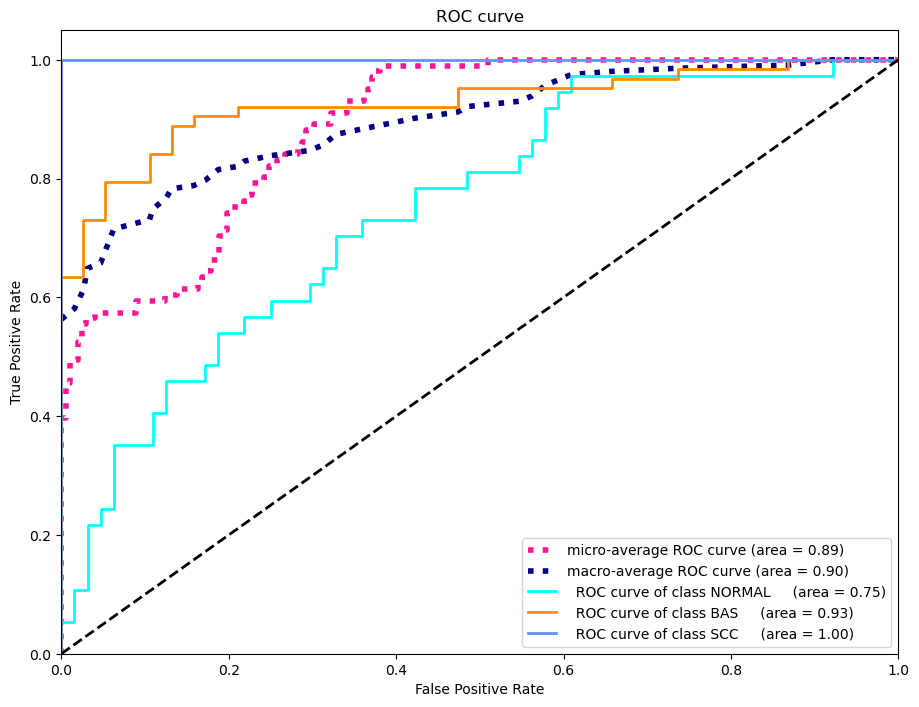

Epoch 19


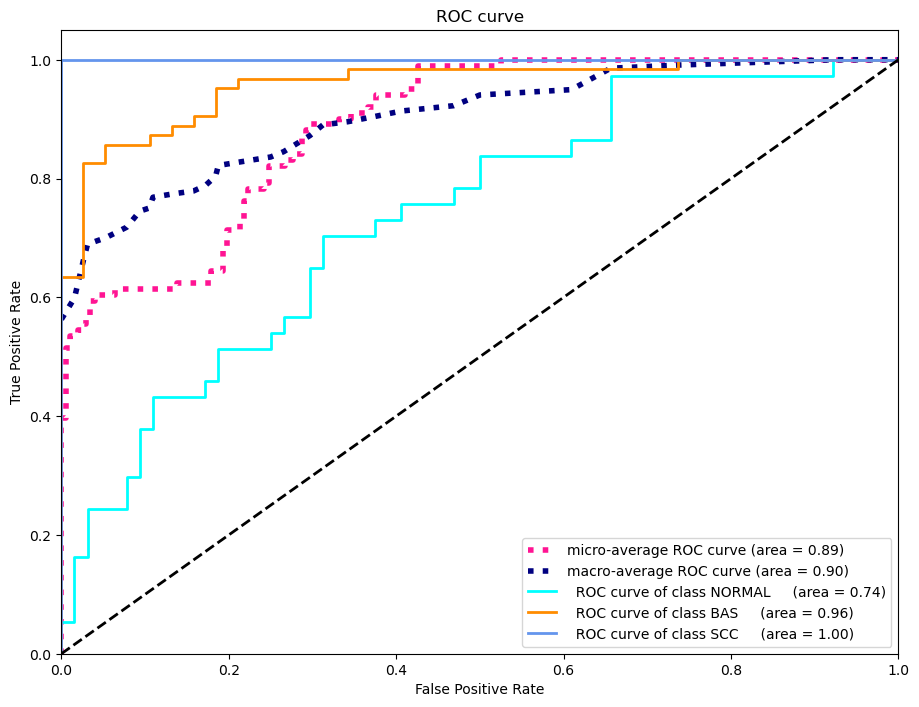

Epoch 20


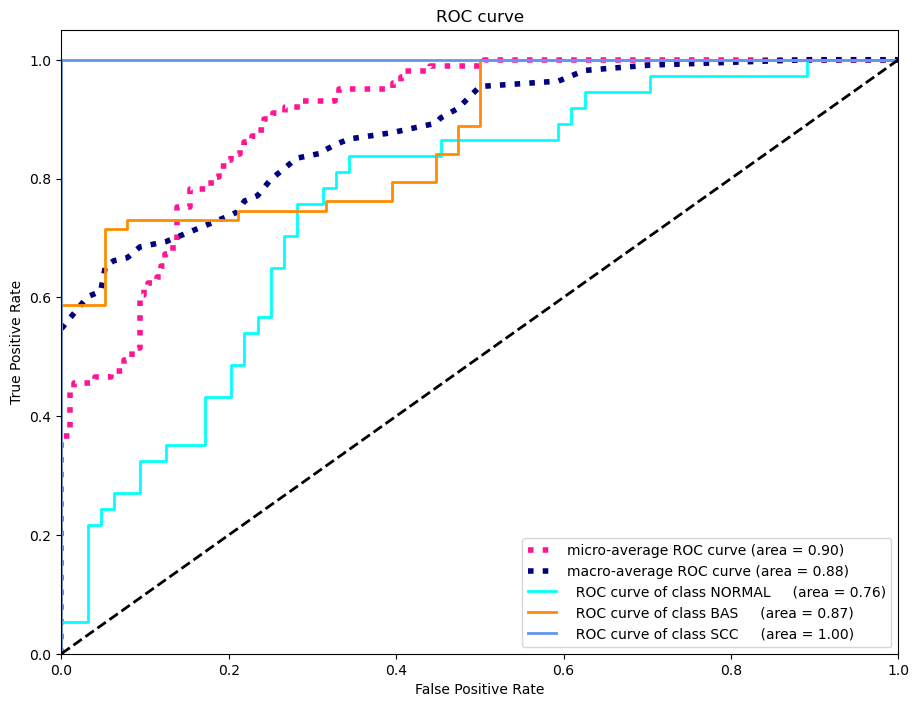

Epoch 21


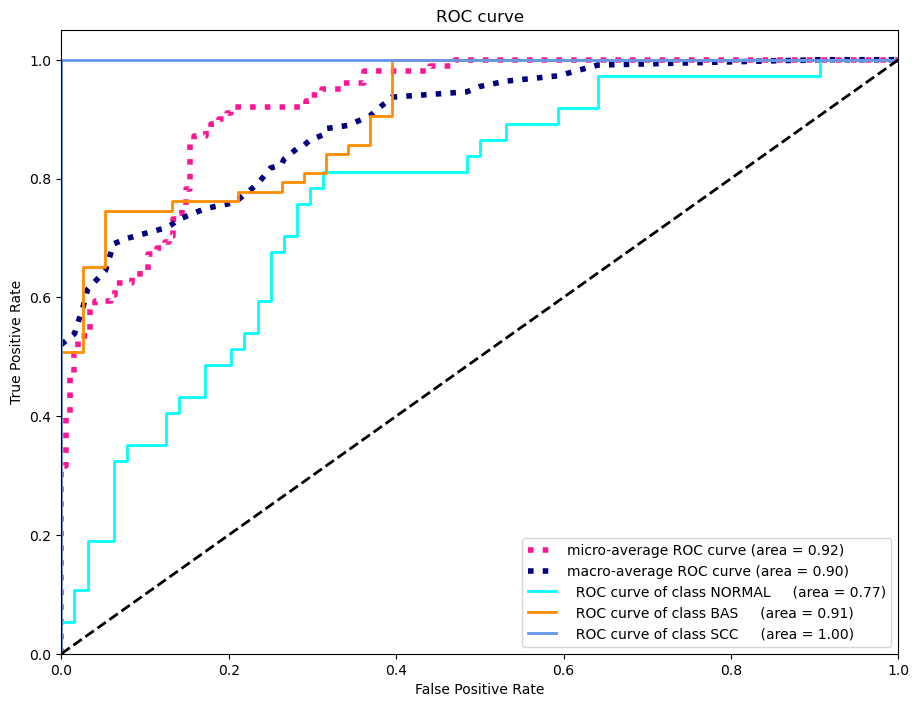

Epoch 22


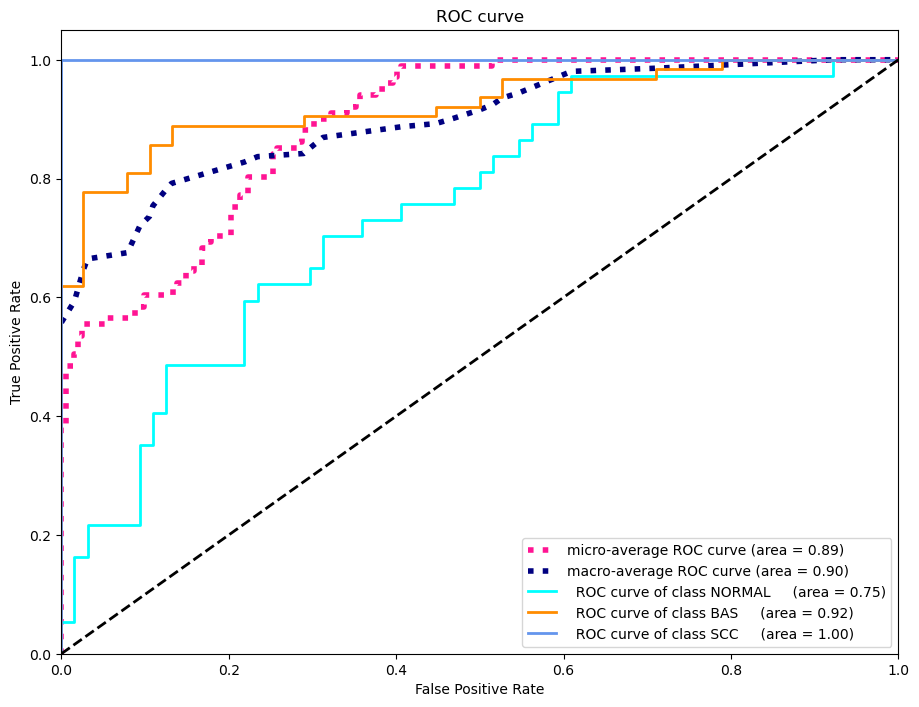

Epoch 23


In [67]:

train(config)